In [1]:
# move to the home directory of iparaphrasing.
% cd /home/mayu-ot/Documents/iparaphrasing-master/

# set the path of the flickr30K entities dataset.
Flickr30K_BASE = '/home/mayu-ot/Data/Dataset/Flickr30kEntities/'

/home/mayu-ot/Documents/iparaphrasing-master


In [2]:
import sys
sys.path.append('script/training/')
from train_paraphrase_classifier import *
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Figure 4

In [3]:
import skimage.transform
import skimage.io

def show_attention(im_id, alpha1, alpha2, root=Flickr30K_BASE+'flickr30k-images/'):
    im = skimage.io.imread(root+'%i.jpg'%im_id)
    im = skimage.transform.resize(im, (224, 224))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
    extent = (0, 14, 0, 14)
    vmin = min(alpha1.data.min(), alpha2.data.min())
    vmax = max(alpha1.data.max(), alpha2.data.max())

    ax1.imshow(im)
    ax1.axis('off')
    
    alpha_img = skimage.transform.pyramid_expand(alpha1.data[0].reshape(14, 14), upscale=im.shape[0] / 14, sigma=20)
    ax2.imshow(im, cmap=plt.cm.gray, interpolation='bilinear', extent=extent)
    ax2.imshow(alpha_img, alpha=0.8, cmap=plt.cm.Greys_r, extent=extent) 
    ax2.axis('off')

    alpha_img = skimage.transform.pyramid_expand(alpha2.data[0].reshape(14, 14), upscale=im.shape[0] / 14, sigma=20)
    ax3.imshow(im, cmap=plt.cm.gray, interpolation='bilinear', extent=extent)
    ax3.imshow(alpha_img, alpha=0.8, cmap=plt.cm.Greys_r, extent=extent)
    ax3.axis('off')

In [4]:
dataset, conv_c = get_dataset('fv+cca', image_net='vgg', split='test')

('fv+cca', 'vgg', 'test')


In [5]:
p_dir = 'models/fv+cca-None/'
v_dir = 'models/fv+cca-vgg/'
res1 = pd.read_csv(p_dir+'eval_w_tuned_thres_test.csv')
res2 = pd.read_csv(v_dir+'eval_w_tuned_thres_test.csv')

In [6]:
p_model = setup_model('fv+cca', None)
chainer.serializers.load_npz(p_dir + 'model', p_model)

In [7]:
v_model = setup_model('fv+cca', 'vgg')
chainer.serializers.load_npz(v_dir + 'model', v_model)

In [8]:
# for original phrases
ref_df = pd.read_csv('data/phrase_pair_remove_trivial_match_test.csv')

/home/mayu-ot/miniconda2/envs/chainer/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


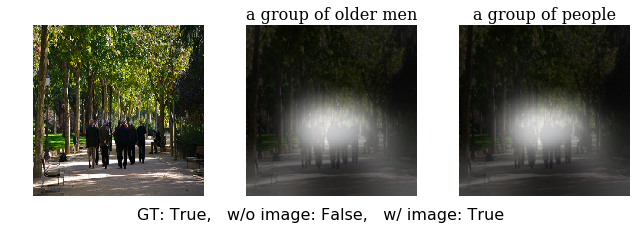

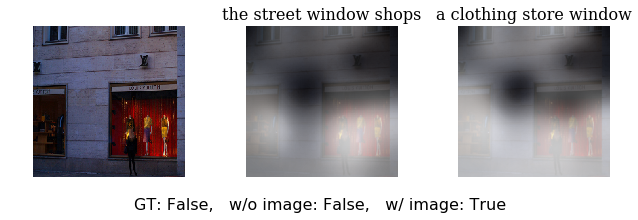

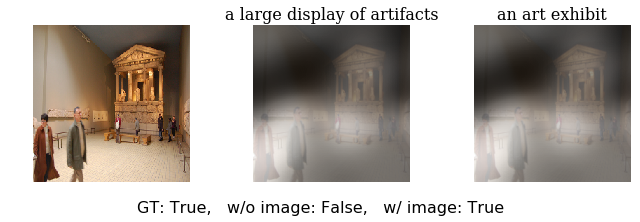

In [9]:
with function.no_backprop_mode(), chainer.using_config('train', False):
    for i in [895, 28996, 77011]:
        Xim, Xp1, Xp2, Y = conv_c(dataset[i:i+1])

        Hp1 = v_model.encode_phrase(Xp1)
        Hp2 = v_model.encode_phrase(Xp2)

        # extract feature map from cnn
        features = v_model._ext_fun(Xim)

        features = v_model.bn(features)
        features_proj = v_model.project_features(features)
        features = F.reshape(features, (-1, v_model.C, v_model.D))

        # get context
        context1, alpha1 = v_model.attention_layer(features, features_proj, Hp1)
        context2, alpha2 = v_model.attention_layer(features, features_proj, Hp2)

        h1 = v_model.fuse_layer(context1, Hp1)
        h2 = v_model.fuse_layer(context2, Hp2)

        h = v_model.classification_layer(h1, h2)
        p_l = F.sigmoid(h).data[0, 0] > .5

        show_attention(res1.image[i], alpha1, alpha2)
        ax_list = plt.gcf().axes
        ax_list[1].set_title(ref_df.original_phrase1[i].lower(), fontsize=16, family='serif')
        ax_list[2].set_title(ref_df.original_phrase2[i].lower(), fontsize=16, family='serif')
        plt.gcf().suptitle('GT: %s,   w/o image: %s,   w/ image: %s'%(bool(Y[0, 0]), res1.ypred[i], res2.ypred[i]), y=.05, fontsize=16)
        plt.tight_layout()
        plt.show()
        plt.close('all')

# Figure 5

In [10]:
from func.util.flickr30Kentities_util import load_bbox, load_entity

def add_bbox(bb, ax, h, w, caption=None):
    y_min, x_min, y_max, x_max = bb
    
    xy = (x_min, y_min)
    width = x_max - x_min
    height = y_max - y_min
    ax.add_patch(plt.Rectangle(
        xy, width, height, fill=False, edgecolor='yellow', linewidth=2))

    if caption is None:
        return

    ax.text(bb[0], bb[1],
            caption,
            style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 2})

/home/mayu-ot/miniconda2/envs/chainer/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [11]:
data_id = 2113996953 # 2229177914, 2113996953, 4878415659
bbox_list = load_bbox(Flickr30K_BASE+'Annotations/%i.xml'%data_id)

In [12]:
id_entitiey = load_entity(Flickr30K_BASE+'Sentences/%i.txt'%data_id)
id_entitiey

{'0': ['it', 'her'],
 '29517': ['An Asian woman',
  'A smiling Asian woman',
  'A lady',
  'A woman',
  'A woman'],
 '29518': ['a hat', 'a conical hat'],
 '29519': ['a curb',
  'a sidewalk',
  'the round',
  'the side of the rode',
  'a sidewalk'],
 '29521': ['her bananas', 'two baskets of bananas', 'bananas', 'fruit'],
 '29522': ['two fruit baskets']}

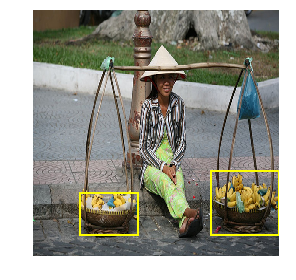

In [13]:
im = skimage.io.imread(Flickr30K_BASE+'flickr30k-images/%i.jpg'%data_id)
plt.imshow(im)

keywords = ['bananas', 'fruit']

for bb_id, ent in id_entitiey.items():
    if any([kw in ent for kw in keywords]):
        bbox_loc = [bb for bb in bbox_list if bb_id in bb[-1]]
        for bb in bbox_loc:
            add_bbox(bb[0], plt.gca(), h=im.shape[0], w=im.shape[1])

plt.gca().set_aspect(im.shape[1]*1./im.shape[0])
plt.axis('off')

plt.tight_layout()
plt.show()